### Import related libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from time import time
from datetime import datetime
from datetime import timedelta
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [7]:
#!pip install pystan fbprophet

In [8]:
# parser = lambda date: pd.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
# df = pd.read_csv('bags.csv', parse_dates=['InvoiceDate'], date_parser = True)

In [9]:
#Import the dataset 
df = pd.read_csv('bags.csv')

In [3]:
#Create function to convert dataframe to time series data:

def prepare_timeseries_data(df):
    col=[0,3]
    df.drop(df.columns[col], axis=1, inplace=True)
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df.columns=['Quantity','ds']
    df['ds'] = pd.to_datetime(df['ds']).dt.date

    df= df.groupby('ds').sum().reset_index()
    df.set_index(df['ds'],inplace=True)
    return df
    

In [11]:
#df.columns= [['Date','Quantity']]
df= prepare_timeseries_data(df)
df

,ds,Quantity
ds,,
2010-12-01,2010-12-01,551
2010-12-02,2010-12-02,681
2010-12-03,2010-12-03,865
2010-12-05,2010-12-05,446
2010-12-06,2010-12-06,512
...,...,...
2011-12-05,2011-12-05,918
2011-12-06,2011-12-06,1593
2011-12-07,2011-12-07,1500


array([[<AxesSubplot:title={'center':'Quantity'}>]], dtype=object)

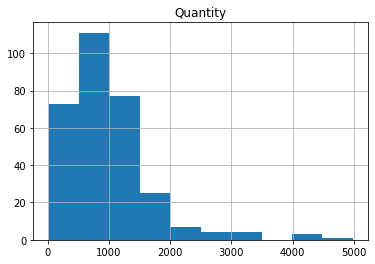

In [12]:
df.hist() # This indicates data is left skewed.

In [13]:
df['ds']= pd.to_datetime(df['ds'])
data = pd.DataFrame({'Datetime':df['ds'],'Quantity':df['Quantity']})
data.index= pd.to_datetime(data.index)

<AxesSubplot:>

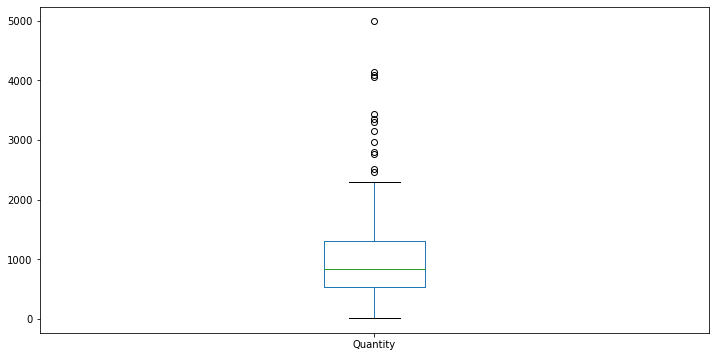

In [14]:
df.boxplot(grid=False, figsize=(12,6))

<AxesSubplot:xlabel='Month', ylabel='Quantity'>

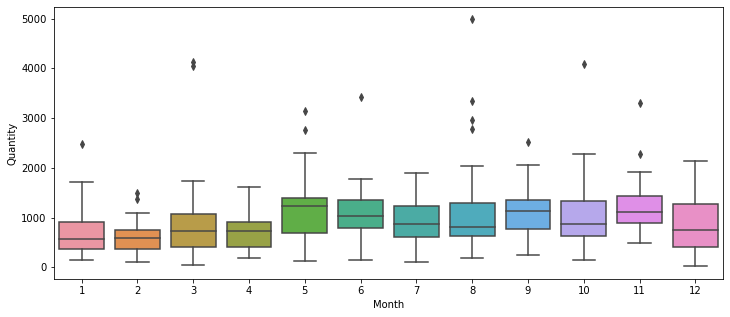

In [15]:
plt.figure(figsize= (12,5))
data['Month'] = data.index.month
sns.boxplot(data=data,x='Month',y='Quantity')

In [16]:
# outliers =df[df['Quantity']>=3000].index.values
# lst= [3,5,6,8,10,11 ]
# impute=[]
# i=0
# for i in lst:
#     a=temp[temp['ds']==i]['Quantity'].median()
    
#     i=i+1
#     impute.append(a)

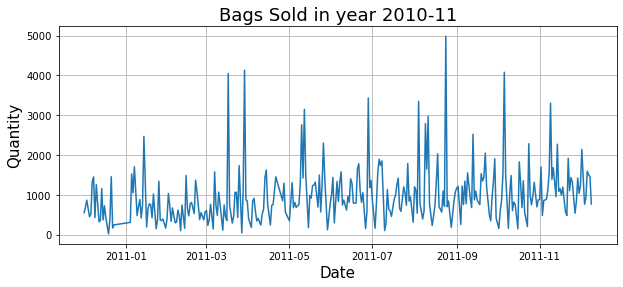

In [17]:
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(df['ds'],df['Quantity'])
plt.title('Bags Sold in year 2010-11', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.show()

#### Check for stationarity

<AxesSubplot:xlabel='ds'>

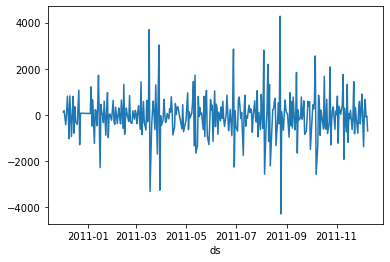

In [18]:
diff= df['Quantity'].diff().dropna()
diff.plot()

In [23]:
#ADF
def check_stationarity(df):
    dftest= adfuller(df['Quantity'], autolag='AIC')
    print('1.ADF =',dftest[0])
    print('2.P-value =',dftest[1])
    print('3.No. of lags=',dftest[2])
    print('4.No. of obs used for ADF regression and critical value calculation =',dftest[3])
    print('Critical values')
    for key, value in dftest[4].items():
        print("\t",key, ";",value)

In [20]:
check_stationarity(df)

1.ADF = -5.287108032875574
2.P-value = 5.822586700346181e-06
3.No. of lags= 5
4.No. of obs used for ADF regression and critical value calculation = 299
Critical values
	 1% ; -3.4524113009049935
	 5% ; -2.8712554127251764
	 10% ; -2.571946570731871


### Split the data into train and test

In [21]:
#Split data into train and test:

train = df[:int(0.9*(len(df)))]
test = df[int(0.9*len(df)):]

### Plot ACF & PACF plots

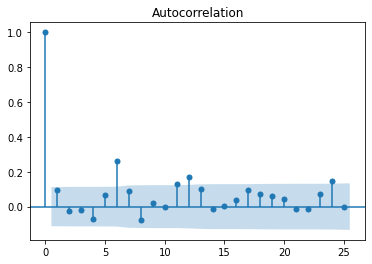

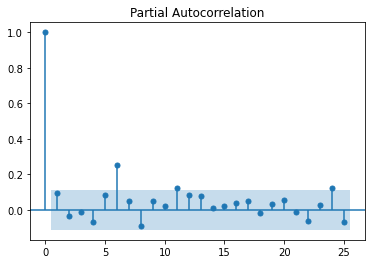

In [22]:
plot_acf(df['Quantity']);
plot_pacf(df['Quantity']);

### ARIMA model

In [23]:
#Train the model:
model = ARIMA(train['Quantity'],order=(5,0,4))
model= model.fit()
pred= model.predict(start= 274, end=304)   #Validate on the test data
 
arima_model_perf = sqrt(mean_squared_error(test['Quantity'],pred))
print("The performance of ARIMA model :",arima_model_perf)
    
   #Forecast the future values:
future_dates= pd.date_range(start='2011-12-09',end='2012-02-06' )
m_fcast= ARIMA(df['Quantity'],order=(5,0,4))
m_fcast= m_fcast.fit(disp=0)
fcast= m_fcast.predict(start=len(df),end=len(df)+60 )

The performance of ARIMA model : 573.0084409170727


In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Quantity   No. Observations:                  274
Model:                     ARMA(5, 4)   Log Likelihood               -2201.528
Method:                       css-mle   S.D. of innovations            741.270
Date:                Fri, 17 Dec 2021   AIC                           4425.055
Time:                        11:55:27   BIC                           4464.800
Sample:                             0   HQIC                          4441.008
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1303.7165        nan        nan        nan         nan         nan
ar.L1.Quantity     0.5502      0.269      2.046      0.041       0.023       1.077
ar.L2.Quantity    -0.0880      0.527     -0.167      0.867      -1.121       0.945
ar.L3.Quantity    -0.0740      0.552     -0.134      0.893      -1.155       1.007
ar.L4.Quantity     0.7787      0.604      1.288      0.198      -0.406       1.963
ar.L5.Quantity    -0.1670      0.330     -0.506      0.613      -0.814       0.480
ma.L1.Quantity    -0.3058      0.530     -0.577      0.564      -1.344       0.733
ma.L2.Quantity     0.1031      0.588      0.175      0.861      -1.050       1.256
ma.L3.Quantity     0.1128      0.639      0.177      0.860      -1.140       1.365
ma.L4.Quantity    -0.9102      0.581     -1.566      0.117      -2.049       0.229
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1391           -0.0000j            1.1391           -0.5000
AR.2            0.1203           -1.0667j            1.0735           -0.2321
AR.3            0.1203           +1.0667j            1.0735            0.2321
AR.4            1.0000           -0.0000j            1.0000           -0.0000
AR.5            4.5601           -0.0000j            4.5601           -0.0000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.1097           -0.9955j            1.0015           -0.2325
MA.3            0.1097           +0.9955j            1.0015            0.2325
MA.4           -1.0954           -0.0000j            1.0954           -0.5000
-----------------------------------------------------------------------------
"""

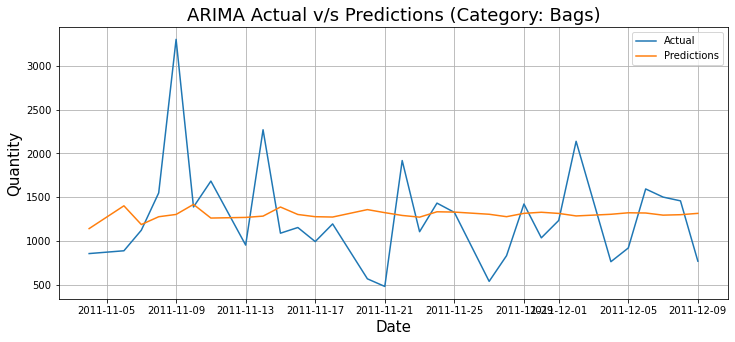

In [25]:
plt.figure(figsize=(12,5))
plt.grid()
plt.title('ARIMA Actual v/s Predictions (Category: Bags)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)

plt.plot(test.index,test['Quantity'])
plt.plot(test.index,pred)
plt.legend(('Actual', 'Predictions'))
plt.show()
plt.show()#test['y'].plot(legend=True)

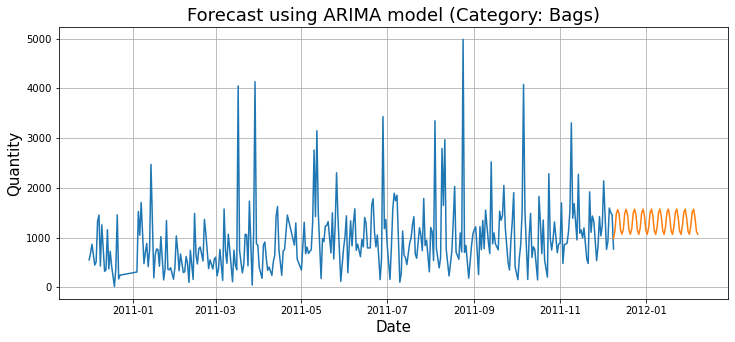

In [26]:

future_dates= pd.date_range(start='2011-12-09',end='2012-02-07' )
fig = plt.figure(figsize=(12,5))
plt.grid()
plt.title('Forecast using ARIMA model (Category: Bags)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.plot(df.index,df['Quantity'])
plt.plot(future_dates,fcast)
plt.show()

### Exponential Smoothing

In [27]:
model_exp = ExponentialSmoothing(train['Quantity'], seasonal_periods=12,
                                 trend='add',seasonal='mul',damped=True
                                ).fit(optimized=True,use_boxcox=True)
pred = np.round(model_exp.forecast(len(test)))
pred = model_exp.predict(start= 274, end=304)
EXP_perf = sqrt(mean_squared_error(test['Quantity'],pred))

In [28]:

print(EXP_perf)


676.457996075476


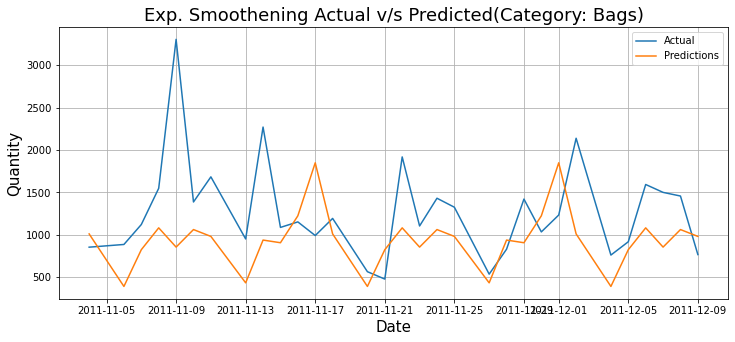

In [29]:
#plot-1

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(test.index,test['Quantity'])
plt.plot(test.index,pred)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.title('Exp. Smoothening Actual v/s Predicted(Category: Bags)',fontsize=18)
plt.legend(('Actual', 'Predictions'))
plt.show()

In [30]:
#Forecast
future_dates= pd.date_range(start='2011-12-09',end='2012-02-07' )
model2=ExponentialSmoothing(df['Quantity'], seasonal_periods=30,
                                 trend='add', seasonal='mul', damped=True
                                )
model2= model2.fit(optimized=True,use_boxcox=True)

pred= model2.predict(start=len(df),end=len(df)+60).rename('Exp. Smoothing Predictions')
pred.index= future_dates

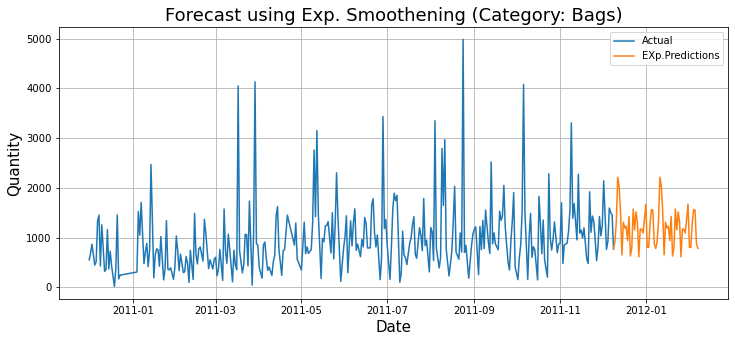

In [31]:
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(df.index,df['Quantity'])
plt.plot(pred.index,pred)
plt.title('Forecast using Exp. Smoothening (Category: Bags)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.legend(('Actual', 'EXp.Predictions'))
plt.show()

### LSTM

In [32]:
#Split train- test set
df2= df.copy()
df2.drop(df2.columns[0], axis=1, inplace=True)
train= df2.iloc[:275]
test= df2.iloc[275:]

In [33]:
scaler= MinMaxScaler()
new_df=scaler.fit_transform(np.array(df2))
train= new_df[0:275]
test= new_df[len(train):len(df)]

In [34]:
#Lets Consider time steps(window) to be 5
n_input = 5
n_features = 1
def train_test_data(df,n_input):
    X,y= [],[]
    i=0
    for i in range(len(df)-n_input-1):
        
        X.append(df[i:i+n_input,0])
        y.append(df[i+n_input,0])
        i+=1
    return np.array(X), np.array(y)

In [35]:
Xtrain, ytrain= train_test_data(train,n_input)
Xtest, ytest= train_test_data(test,n_input)

#Reshape the data as LSTM requires data to be 3dimensions

Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

In [36]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences= True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [37]:
# fit model
history=model.fit(Xtrain,ytrain,epochs=400,verbose=1,validation_data=(Xtest, ytest))

Instructions for updating:
Use tf.cast instead.
Train on 269 samples, validate on 24 samples
Epoch 1/400
269/269 [==============================] - 1s 5ms/step - loss: 0.0477 - val_loss: 0.0413
Epoch 2/400
269/269 [==============================] - 0s 235us/step - loss: 0.0325 - val_loss: 0.0205
Epoch 3/400
269/269 [==============================] - 0s 184us/step - loss: 0.0233 - val_loss: 0.0092
Epoch 4/400
269/269 [==============================] - 0s 180us/step - loss: 0.0219 - val_loss: 0.0092
Epoch 5/400
269/269 [==============================] - 0s 175us/step - loss: 0.0216 - val_loss: 0.0105
Epoch 6/400
269/269 [==============================] - 0s 142us/step - loss: 0.0212 - val_loss: 0.0108
Epoch 7/400
269/269 [==============================] - 0s 223us/step - loss: 0.0212 - val_loss: 0.0103
Epoch 8/400
269/269 [==============================] - 0s 180us/step - loss: 0.0212 - val_loss: 0.0102
Epoch 9/400
269/269 [==============================] - 0s 174us/step - loss: 0.0212 -

Epoch 77/400
269/269 [==============================] - 0s 123us/step - loss: 0.0207 - val_loss: 0.0126
Epoch 78/400
269/269 [==============================] - 0s 178us/step - loss: 0.0206 - val_loss: 0.0140
Epoch 79/400
269/269 [==============================] - 0s 189us/step - loss: 0.0208 - val_loss: 0.0118
Epoch 80/400
269/269 [==============================] - 0s 152us/step - loss: 0.0205 - val_loss: 0.0134
Epoch 81/400
269/269 [==============================] - 0s 221us/step - loss: 0.0206 - val_loss: 0.0126
Epoch 82/400
269/269 [==============================] - 0s 244us/step - loss: 0.0207 - val_loss: 0.0119
Epoch 83/400
269/269 [==============================] - 0s 289us/step - loss: 0.0205 - val_loss: 0.0136
Epoch 84/400
269/269 [==============================] - 0s 212us/step - loss: 0.0206 - val_loss: 0.0131
Epoch 85/400
269/269 [==============================] - 0s 170us/step - loss: 0.0205 - val_loss: 0.0121
Epoch 86/400
269/269 [==============================] - 0s 172us

269/269 [==============================] - 0s 199us/step - loss: 0.0204 - val_loss: 0.0164
Epoch 156/400
269/269 [==============================] - 0s 134us/step - loss: 0.0204 - val_loss: 0.0176
Epoch 157/400
269/269 [==============================] - 0s 170us/step - loss: 0.0199 - val_loss: 0.0128
Epoch 158/400
269/269 [==============================] - 0s 165us/step - loss: 0.0200 - val_loss: 0.0146
Epoch 159/400
269/269 [==============================] - 0s 188us/step - loss: 0.0199 - val_loss: 0.0153
Epoch 160/400
269/269 [==============================] - 0s 162us/step - loss: 0.0198 - val_loss: 0.0161
Epoch 161/400
269/269 [==============================] - 0s 194us/step - loss: 0.0198 - val_loss: 0.0147
Epoch 162/400
269/269 [==============================] - 0s 178us/step - loss: 0.0199 - val_loss: 0.0158
Epoch 163/400
269/269 [==============================] - 0s 135us/step - loss: 0.0199 - val_loss: 0.0156
Epoch 164/400
269/269 [==============================] - 0s 237us/ste

269/269 [==============================] - 0s 185us/step - loss: 0.0193 - val_loss: 0.0200
Epoch 312/400
269/269 [==============================] - 0s 159us/step - loss: 0.0188 - val_loss: 0.0178
Epoch 313/400
269/269 [==============================] - 0s 212us/step - loss: 0.0189 - val_loss: 0.0222
Epoch 314/400
269/269 [==============================] - 0s 191us/step - loss: 0.0190 - val_loss: 0.0193
Epoch 315/400
269/269 [==============================] - 0s 155us/step - loss: 0.0187 - val_loss: 0.0193
Epoch 316/400
269/269 [==============================] - 0s 215us/step - loss: 0.0190 - val_loss: 0.0194
Epoch 317/400
269/269 [==============================] - 0s 126us/step - loss: 0.0188 - val_loss: 0.0206
Epoch 318/400
269/269 [==============================] - 0s 213us/step - loss: 0.0187 - val_loss: 0.0188
Epoch 319/400
269/269 [==============================] - 0s 151us/step - loss: 0.0190 - val_loss: 0.0222
Epoch 320/400
269/269 [==============================] - 0s 288us/ste

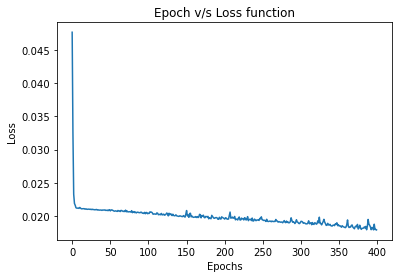

In [38]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch v/s Loss function')
plt.show()

In [39]:
#Predict the y-values
train_pred=model.predict(Xtrain)
test_pred=model.predict(Xtest)

#Convert the values to original values
train_pred=scaler.inverse_transform(train_pred)
test_pred=scaler.inverse_transform(test_pred)

## Check performance

lstm_perf=sqrt(mean_squared_error(ytrain,train_pred))
lstm_perf

1022.8826911466133

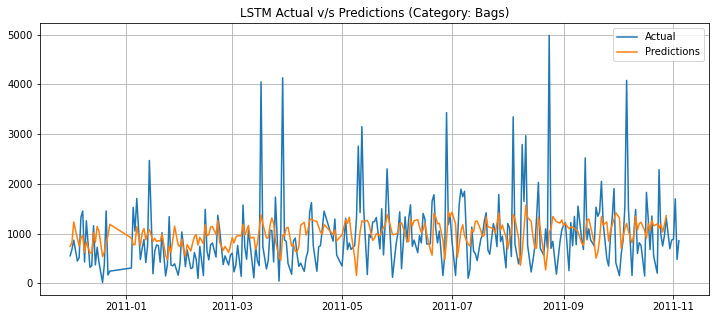

In [40]:
#Plot-1: Actual v/s prediction train set

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(df[0:275].index,scaler.inverse_transform(train))
plt.plot(df[0:269].index,train_pred)
plt.title('LSTM Actual v/s Predictions (Category: Bags)')
plt.legend(('Actual', 'Predictions'))
plt.show()

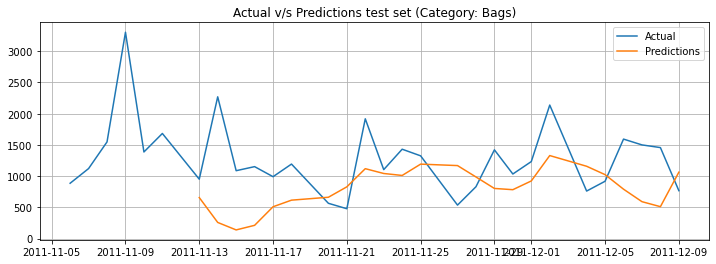

In [41]:
#Plot-2

plt.figure(figsize=(12,4))
plt.grid()
plt.plot(df[275:].index,scaler.inverse_transform(test))
plt.plot(df[281:].index,test_pred)
plt.title('Actual v/s Predictions test set (Category: Bags)')
plt.legend(('Actual', 'Predictions'))
plt.show()

In [42]:
xinput= test[25:].reshape(1,-1)
xinput.shape
temp_ip=list(xinput)
temp_ip=temp_ip[0].tolist()
temp_ip

[0.18156199677938809,
 0.31743156199677935,
 0.29871175523349436,
 0.29005636070853463,
 0.15116747181964574]

In [43]:
## Forecasting for next 60 days

lst_op=[]
n_steps=5
i=0
while(i<60):
    
    if(len(temp_ip)>5):
        #print(temp_input)
        xinput=np.array(temp_ip[1:])
        print("{} day input {}".format(i,xinput))
        xinput=xinput.reshape(1,-1)
        xinput = xinput.reshape((1,n_steps, 1))
        #print(x_input)
        yhat = model.predict(xinput, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_ip.extend(yhat[0].tolist())
        temp_ip=temp_ip[1:]
        #print(temp_input)
        lst_op.extend(yhat.tolist())
        i=i+1
    else:
        xinput = xinput.reshape((1,n_steps,1))
        yhat = model.predict(xinput, verbose=0)
        print(yhat[0])
        temp_ip.extend(yhat[0].tolist())
        print(len(temp_ip))
        lst_op.extend(yhat.tolist())
        i=i+1
    

print(lst_op)

[0.13017692]
6
1 day input [0.31743156 0.29871176 0.29005636 0.15116747 0.13017692]
1 day output [[0.12121533]]
2 day input [0.29871176 0.29005636 0.15116747 0.13017692 0.12121533]
2 day output [[0.19230041]]
3 day input [0.29005636 0.15116747 0.13017692 0.12121533 0.19230041]
3 day output [[0.25980282]]
4 day input [0.15116747 0.13017692 0.12121533 0.19230041 0.25980282]
4 day output [[0.2586013]]
5 day input [0.13017692 0.12121533 0.19230041 0.25980282 0.25860131]
5 day output [[0.25375408]]
6 day input [0.12121533 0.19230041 0.25980282 0.25860131 0.25375408]
6 day output [[0.23291251]]
7 day input [0.19230041 0.25980282 0.25860131 0.25375408 0.23291251]
7 day output [[0.18421215]]
8 day input [0.25980282 0.25860131 0.25375408 0.23291251 0.18421215]
8 day output [[0.15670648]]
9 day input [0.25860131 0.25375408 0.23291251 0.18421215 0.15670648]
9 day output [[0.18382512]]
10 day input [0.25375408 0.23291251 0.18421215 0.15670648 0.18382512]
10 day output [[0.22758041]]
11 day input [

In [44]:
future_dates= pd.date_range(start='2011-12-09',end='2012-02-06' )
len(future_dates)


60

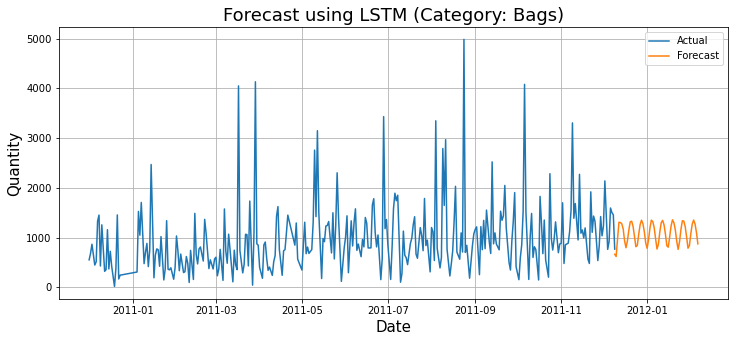

In [45]:

#Plot-3

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(df.index,scaler.inverse_transform(new_df))
plt.plot(future_dates,scaler.inverse_transform(lst_op))
plt.title('Forecast using LSTM (Category: Bags)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.legend(('Actual', 'Forecast'))

### Prophet model

In [46]:
df.columns= ['ds','y']

In [47]:
df['yoriginal']= df['y']
df['y']= np.log(df['yoriginal'])

# df1.columns= ['ds','y']
data = df.loc[:,['ds','y']]
 
    #Split data
train = data[:int(0.9*(len(data)))]
test = data[int(0.9*len(data)):]

# Train the model
m = Prophet()
m.fit(train)

#Validate model on test data
y_pred=m.predict(test)
y_pred.columns
y_pred[['ds','yhat_lower', 'yhat_upper','yhat']]
prop_perf=sqrt(mean_squared_error(test['y'],y_pred['yhat']))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
data.tail()

,ds,y
ds,,
2011-12-05,2011-12-05,6.822197
2011-12-06,2011-12-06,7.373374
2011-12-07,2011-12-07,7.313220
2011-12-08,2011-12-08,7.284135
2011-12-09,2011-12-09,6.642487


In [49]:
#Forecast
future= m.make_future_dataframe(periods=95, freq='D')
fcast=m.predict(future)
fcast.tail()
#fcast[['ds','yhat']]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
364,2012-02-02,6.930917,6.371289,7.884540,6.910501,6.950438,0.206901,0.206901,0.206901,0.206901,0.206901,0.206901,0.0,0.0,0.0,7.137818
365,2012-02-03,6.931742,6.239330,7.846227,6.911088,6.951899,0.127872,0.127872,0.127872,0.127872,0.127872,0.127872,0.0,0.0,0.0,7.059614
366,2012-02-04,6.932567,6.286241,7.779794,6.911602,6.952959,0.072908,0.072908,0.072908,0.072908,0.072908,0.072908,0.0,0.0,0.0,7.005475
367,2012-02-05,6.933392,5.183477,6.677994,6.911993,6.954288,-0.997211,-0.997211,-0.997211,-0.997211,-0.997211,-0.997211,0.0,0.0,0.0,5.936181
368,2012-02-06,6.934217,6.205640,7.783932,6.912429,6.955618,0.054078,0.054078,0.054078,0.054078,0.054078,0.054078,0.0,0.0,0.0,6.988295


In [50]:
fcast[['ds','yhat_lower','yhat','yhat_upper']]

,ds,yhat_lower,yhat,yhat_upper
0,2010-12-01,5.581778,6.360326,7.109534
1,2010-12-02,5.652886,6.371473,7.147469
2,2010-12-03,5.515877,6.295448,7.060321
3,2010-12-05,4.365095,5.176372,5.906972
4,2010-12-06,5.473565,6.230665,6.982186
...,...,...,...,...
364,2012-02-02,6.371289,7.137818,7.884540
365,2012-02-03,6.239330,7.059614,7.846227
366,2012-02-04,6.286241,7.005475,7.779794
367,2012-02-05,5.183477,5.936181,6.677994


In [51]:
# Convert back to original data:

fcast_org = fcast # make sure we save the original forecast data
fcast_org['yhat'] = np.exp(fcast_org['yhat'])
fcast_org['yhat_lower'] = np.exp(fcast_org['yhat_lower'])
fcast_org['yhat_upper'] = np.exp(fcast_org['yhat_upper'])

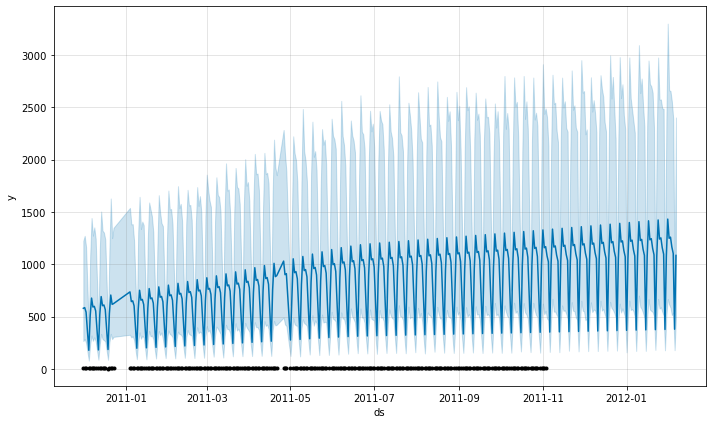

In [52]:
#Plot-1

m.plot(fcast_org);

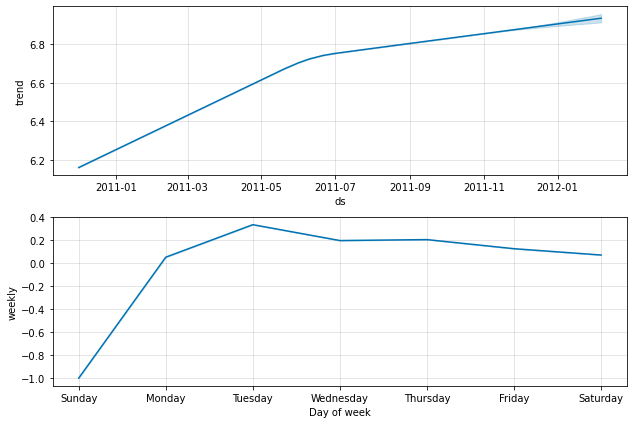

In [53]:
m.plot_components(fcast_org);

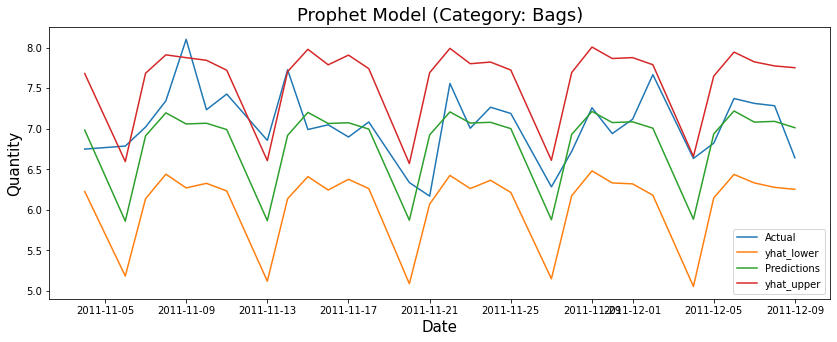

In [54]:
#Plot-2

plt.figure(figsize=(14,5))
plt.title('Prophet Model (Category: Bags)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.plot(test.index,test['y'])
plt.plot(test.index,y_pred[['yhat_lower','yhat','yhat_upper']])
plt.legend(('Actual','yhat_lower', 'Predictions','yhat_upper'))
plt.show()

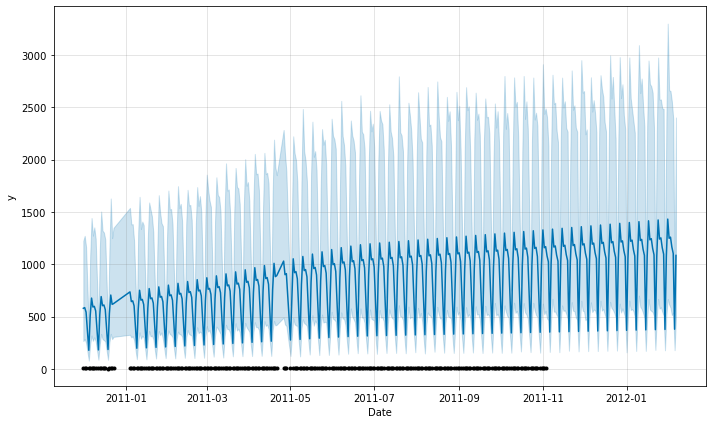

In [55]:
m.plot(fcast_org,xlabel = 'Date');

In [56]:
df_org= pd.DataFrame(fcast_org)

In [64]:
df_org.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [65]:
y_pred=df_org['yhat'][len(train):len(df)]
prop_perf=sqrt(mean_squared_error(test['y'],df_org['yhat']))

NameError: name 'df' is not defined

In [62]:
print("The performance of ARIMA model :",arima_model_perf)
print("The performance of EXP. model :",EXP_perf)
print("The performance of LSTM model :",lstm_perf)
print("The performance of Prophet model :",prop_perf)

The performance of ARIMA model : 573.0084409170727
The performance of EXP. model : 676.457996075476
The performance of LSTM model : 1022.8826911466133
The performance of Prophet model : 1047.3812964505041


In [63]:
#Plot-4 Using plotly

trace1 = go.Scatter(x= df['ds'], y=df["yoriginal"],
                    name= 'Actual Quantity')
trace2 = go.Scatter(x= df_org['ds'][len(df):], y=df_org['yhat'][len(df):],
                    name= 'Forecast')
upper_limit = go.Scatter(name = 'upper limit',x= df_org['ds'],
                         y = df_org['yhat_upper'])

lower_limit = go.Scatter(
    name= 'lower limit', x= df_org['ds'],
    y = df_org['yhat_lower'])

data = [trace1, lower_limit, upper_limit,trace2]

layout = dict(title='FbProphet Forecast (Category : Bags) ',
             xaxis=dict(title = 'Date', ticklen=2, zeroline=True))

figure=dict(data=data,layout=layout)
py.offline.iplot(figure)

## Home Decor dataset

In [17]:
#Import the dataset 
df1 = pd.read_csv('home_decor.csv')

In [18]:
df1= prepare_timeseries_data(df1)
df1

,ds,Quantity
ds,,
2010-12-01,2010-12-01,8801
2010-12-02,2010-12-02,9961
2010-12-03,2010-12-03,5328
2010-12-05,2010-12-05,6150
2010-12-06,2010-12-06,8550
...,...,...
2011-12-05,2011-12-05,16433
2011-12-06,2011-12-06,11815
2011-12-07,2011-12-07,15932


<AxesSubplot:xlabel='Month', ylabel='Quantity'>

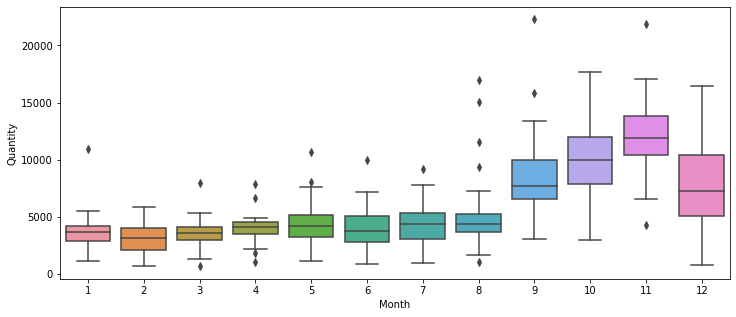

In [19]:
#Check for outliers
df1['ds']= pd.to_datetime(df1['ds'])
data = pd.DataFrame({'Datetime':df1['ds'],'Quantity':df1['Quantity']})
data.index= pd.to_datetime(data.index)
plt.figure(figsize= (12,5))
data['Month'] = data.index.month
sns.boxplot(data=data,x='Month',y='Quantity')

Text(0, 0.5, 'Quantity')

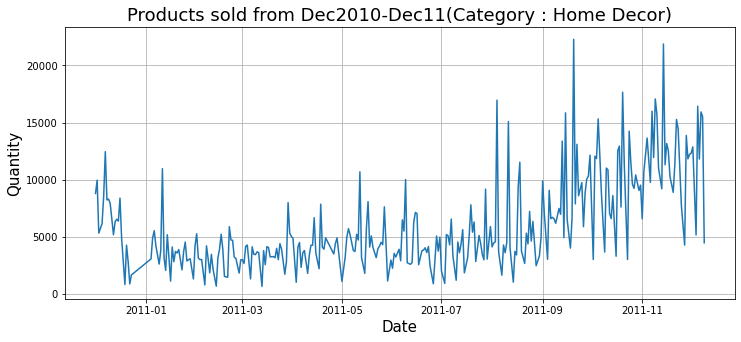

In [20]:
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(df1['ds'],df1['Quantity'])
plt.title('Products sold from Dec2010-Dec11(Category : Home Decor)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)

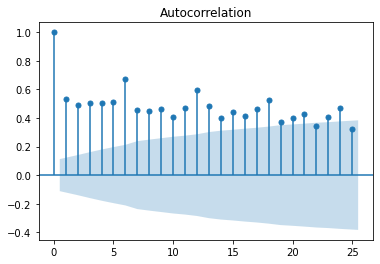

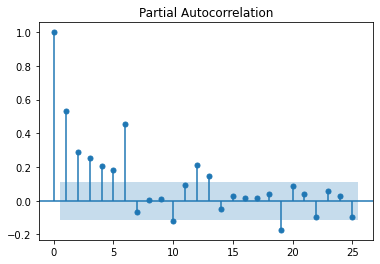

In [21]:
#Plot ACF and PACF 
plot_acf(df1['Quantity']);
plot_pacf(df1['Quantity']);

In [24]:
# Check for stationarity

check_stationarity(df1)

1.ADF = -0.4013223348825848
2.P-value = 0.909877760563002
3.No. of lags= 12
4.No. of obs used for ADF regression and critical value calculation = 292
Critical values
	 1% ; -3.4529449243622383
	 5% ; -2.871489553425686
	 10% ; -2.572071437887033


<AxesSubplot:xlabel='ds'>

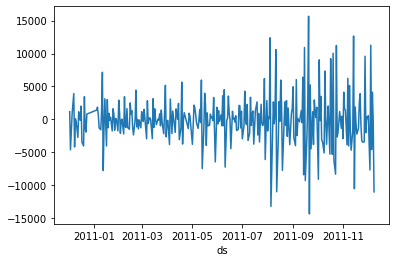

In [25]:
# To convert to stationary

diff= df1['Quantity'].diff(periods=1).dropna()
diff.plot()

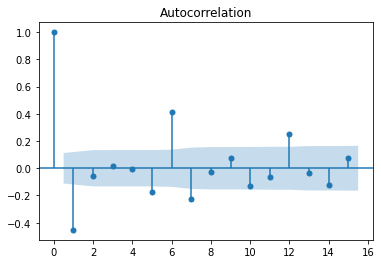

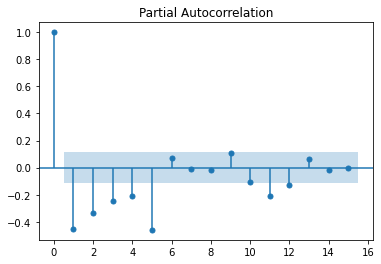

In [26]:
plot_acf(diff,lags=15);
plot_pacf(diff,lags=15);

In [27]:
0.9*305


274.5

In [48]:
#Split train- test set
df2= df1.copy()
df2.drop(df2.columns[0], axis=1, inplace=True)
train= df2.iloc[:275]
test= df2.iloc[275:]


In [29]:
##Auto regressor model
model= AR(train)
model_fit= model.fit()


In [30]:
predict= model_fit.predict(start= 275, end=304)

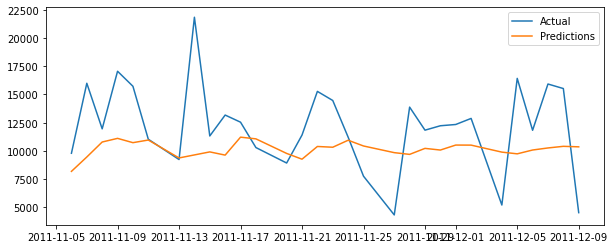

In [31]:
plt.figure(figsize=(10,4))
plt.plot(test.index,test['Quantity'])
plt.plot(test.index,predict)
plt.legend(('Actual', 'Predictions'))
plt.show()

### ARIMA

In [32]:
#Train the model:
model = ARIMA(train,order=(8,0,6))
arima_model= model.fit()
pred= arima_model.predict(start= 275, end=304)   #Validate on the test data
 
arima_model_perf = sqrt(mean_squared_error(test['Quantity'],pred))
print("The performance of ARIMA model :",arima_model_perf)
    
   #Forecast the future values:
future_dates= pd.date_range(start='2011-12-09',end='2012-02-08' )
m_fcast= ARIMA(df1['Quantity'],order=(8,0,6))
m_fcast= m_fcast.fit(disp=0)
fcast= m_fcast.predict(start=len(df1),end=len(df1)+61 )

The performance of ARIMA model : 4324.260853805385


In [33]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Quantity   No. Observations:                  275
Model:                     ARMA(8, 6)   Log Likelihood               -2539.336
Method:                       css-mle   S.D. of innovations           2379.284
Date:                Fri, 17 Dec 2021   AIC                           5110.671
Time:                        15:33:56   BIC                           5168.539
Sample:                             0   HQIC                          5133.895
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5358.4459        nan        nan        nan         nan         nan
ar.L1.Quantity     0.4545    6.1e-06   7.45e+04      0.000       0.455       0.455
ar.L2.Quantity    -0.0111        nan        nan        nan         nan         nan
ar.L3.Quantity     0.2622   4.49e-06   5.84e+04      0.000       0.262       0.262
ar.L4.Quantity    -0.2596   9.63e-06  -2.69e+04      0.000      -0.260      -0.260
ar.L5.Quantity     0.0281        nan        nan        nan         nan         nan
ar.L6.Quantity     0.7124        nan        nan        nan         nan         nan
ar.L7.Quantity    -0.2399        nan        nan        nan         nan         nan
ar.L8.Quantity     0.0316   3.85e-05    820.722      0.000       0.032       0.032
ma.L1.Quantity    -0.3437      0.054     -6.367      0.000      -0.449      -0.238
ma.L2.Quantity     0.0232      0.055      0.418      0.676      -0.085       0.132
ma.L3.Quantity    -0.2847      0.053     -5.366      0.000      -0.389      -0.181
ma.L4.Quantity     0.4705      0.048      9.754      0.000       0.376       0.565
ma.L5.Quantity     0.0911      0.058      1.581      0.114      -0.022       0.204
ma.L6.Quantity    -0.4594      0.057     -8.039      0.000      -0.571      -0.347
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1564           -0.0000j            1.1564           -0.5000
AR.2           -0.5115           -0.8593j            1.0000           -0.3354
AR.3           -0.5115           +0.8593j            1.0000            0.3354
AR.4            1.0067           -0.0000j            1.0067           -0.0000
AR.5            0.6154           -0.9153j            1.1029           -0.1558
AR.6            0.6154           +0.9153j            1.1029            0.1558
AR.7            3.7655           -2.8563j            4.7262           -0.1033
AR.8            3.7655           +2.8563j            4.7262            0.1033
MA.1            1.1901           -0.0000j            1.1901           -0.0000
MA.2            0.7318           -0.8304j            1.1068           -0.1350
MA.3            0.7318           +0.8304j            1.1068            0.1350
MA.4           -0.5192           -0.8854j            1.0264           -0.3344
MA.5           -0.5192           +0.8854j            1.0264            0.3344
MA.6           -1.4171           -0.0000j            1.4171           -0.5000
-----------------------------------------------------------------------------
"""

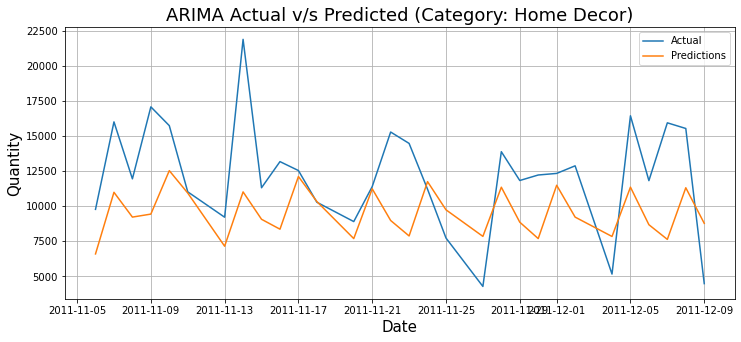

In [34]:
#Plot-1
plt.figure(figsize=(12,5))
plt.grid()
plt.title('ARIMA Actual v/s Predicted (Category: Home Decor)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.plot(test.index,test['Quantity'])
plt.plot(test.index,pred)
plt.legend(('Actual', 'Predictions'))
plt.show()

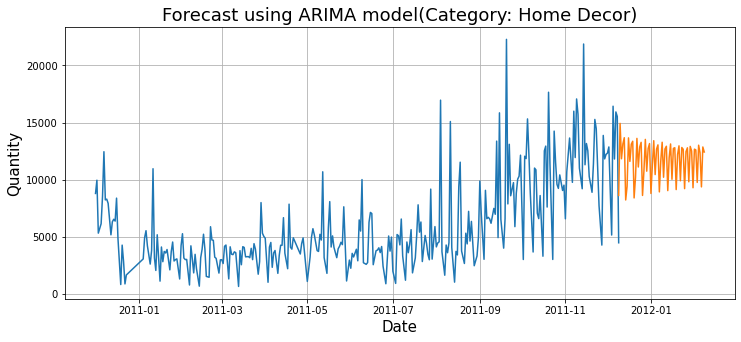

In [35]:
#Plot-2

future_dates= pd.date_range(start='2011-12-09',end='2012-02-08' )
plt.figure(figsize=(12,5))
plt.grid()
plt.title('Forecast using ARIMA model(Category: Home Decor)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.plot(df1.index,df1['Quantity'])
plt.plot(future_dates,fcast)
plt.show()

## LSTM

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
new_df=scaler.fit_transform(np.array(df2))
train= new_df[0:275]
test= new_df[len(train):len(df1)]

In [37]:
#Lets Consider time steps(window) to be 5
n_input = 5
n_features = 1
def train_test_data(df,n_input):
    X,y= [],[]
    i=0
    for i in range(len(df)-n_input-1):
        
        X.append(df[i:i+n_input,0])
        y.append(df[i+n_input,0])
        i+=1
    return np.array(X), np.array(y)
#generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [38]:
Xtrain, ytrain= train_test_data(train,n_input)
Xtest, ytest= train_test_data(test,n_input)

#Reshape the data as LSTM requires data to be 3dimensions

Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

In [39]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences= True, input_shape=(n_input, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [40]:
# fit model
history=model.fit(Xtrain,ytrain,epochs=50,verbose=1,validation_data=(Xtest, ytest))

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 269 samples, validate on 24 samples
Epoch 1/50
269/269 [==============================] - 2s 7ms/step - loss: 0.0654 - val_loss: 0.2709
Epoch 2/50
269/269 [==============================] - 0s 337us/step - loss: 0.0514 - val_loss: 0.2218
Epoch 3/50
269/269 [==============================] - 0s 374us/step - loss: 0.0360 - val_loss: 0.1573
Epoch 4/50
269/269 [==============================] - 0s 367us/step - loss: 0.0246 - val_loss: 0.0921
Epoch 5/50
269/269 [==============================] - 0s 371us/step - loss: 0.0219 - val_loss: 0.0759
Epoch 6/50
269/269 [==============================] - 0s 367us/step - loss: 0.0212 - val_loss: 0.0874
Epoch 7/50
269/269 [==============================] - 0s 386us/step - loss: 0.0208 - val_loss: 0.0821
Epoch 8/50
269/269 [==============================] - 0s 366us/step - loss: 0.0202 - val_loss: 0.0612
Epoch 9/50
269/269 [==============================] - 0s 378us/step - loss: 0.0196 - val_loss: 0.0685
Epoch 10/50
269/269 [==================

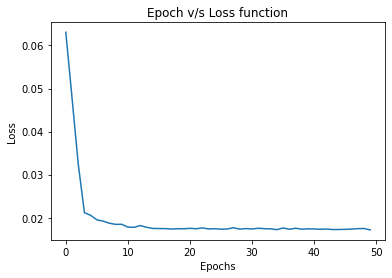

In [94]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch v/s Loss function')
plt.show()

In [41]:
#Predict the y-values
train_pred=model.predict(Xtrain)
test_pred=model.predict(Xtest)

#Convert the values to original values
train_pred=scaler.inverse_transform(train_pred)
test_pred=scaler.inverse_transform(test_pred)

## Check performance

lstm_perf=sqrt(mean_squared_error(ytrain,train_pred))
lstm_perf

5791.206620841326

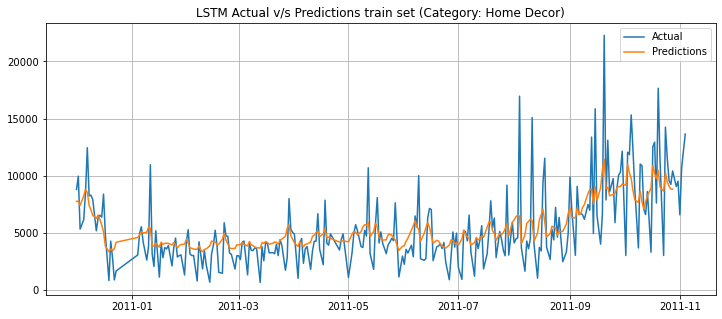

In [42]:
#Plot-1: Actual v/s prediction train set

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(df1[0:275].index,scaler.inverse_transform(train))
plt.plot(df1[0:269].index,train_pred)
plt.title('LSTM Actual v/s Predictions train set (Category: Home Decor)')
plt.legend(('Actual', 'Predictions'))
plt.show()

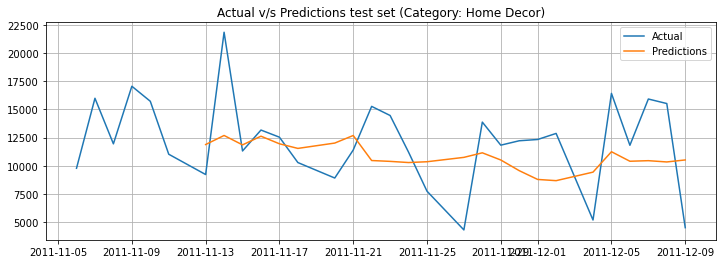

In [43]:
plt.figure(figsize=(12,4))
plt.grid()
plt.plot(df1[275:].index,scaler.inverse_transform(test))
plt.plot(df1[281:].index,test_pred)
plt.title('Actual v/s Predictions test set (Category: Home Decor)')
plt.legend(('Actual', 'Predictions'))
plt.show()

In [44]:
xinput= test[25:].reshape(1,-1)
xinput.shape
temp_ip=list(xinput)
temp_ip=temp_ip[0].tolist()
temp_ip

[0.7294259147892862,
 0.5157977517694408,
 0.7062497108756998,
 0.6876069759911181,
 0.17671277235509092]

[0.52452576]
6
1 day input [0.51579775 0.70624971 0.68760698 0.17671277 0.52452576]
1 day output [[0.47654212]]
2 day input [0.70624971 0.68760698 0.17671277 0.52452576 0.47654212]
2 day output [[0.4687252]]
3 day input [0.68760698 0.17671277 0.52452576 0.47654212 0.4687252 ]
3 day output [[0.42105103]]
4 day input [0.17671277 0.52452576 0.47654212 0.4687252  0.42105103]
4 day output [[0.37221378]]
5 day input [0.52452576 0.47654212 0.4687252  0.42105103 0.37221378]
5 day output [[0.42695677]]
6 day input [0.47654212 0.4687252  0.42105103 0.37221378 0.42695677]
6 day output [[0.40780282]]
7 day input [0.4687252  0.42105103 0.37221378 0.42695677 0.40780282]
7 day output [[0.39648223]]
8 day input [0.42105103 0.37221378 0.42695677 0.40780282 0.39648223]
8 day output [[0.38398588]]
9 day input [0.37221378 0.42695677 0.40780282 0.39648223 0.38398588]
9 day output [[0.37854618]]
10 day input [0.42695677 0.40780282 0.39648223 0.38398588 0.37854618]
10 day output [[0.38261223]]
11 day input [

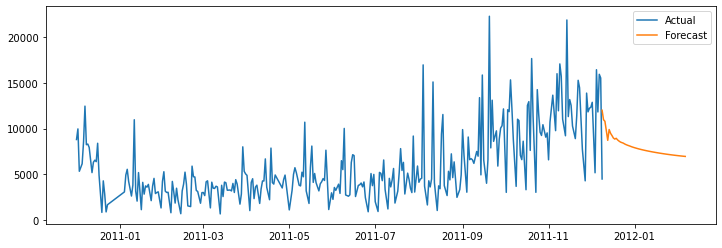

In [45]:
## Forecasting for next 60 days

lst_op=[]
n_steps=5
i=0
while(i<60):
    
    if(len(temp_ip)>5):
        #print(temp_input)
        xinput=np.array(temp_ip[1:])
        print("{} day input {}".format(i,xinput))
        xinput=xinput.reshape(1,-1)
        xinput = xinput.reshape((1,n_steps, 1))
        #print(x_input)
        yhat = model.predict(xinput, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_ip.extend(yhat[0].tolist())
        temp_ip=temp_ip[1:]
        #print(temp_input)
        lst_op.extend(yhat.tolist())
        i=i+1
    else:
        xinput = xinput.reshape((1,n_steps,1))
        yhat = model.predict(xinput, verbose=0)
        print(yhat[0])
        temp_ip.extend(yhat[0].tolist())
        print(len(temp_ip))
        lst_op.extend(yhat.tolist())
        i=i+1
    

print(lst_op)

future_dates= pd.date_range(start='2011-12-09',end='2012-02-06' )
len(future_dates)

#Plot-3

plt.figure(figsize=(12,4))
plt.plot(df1.index,scaler.inverse_transform(new_df))
plt.plot(future_dates,scaler.inverse_transform(lst_op))
plt.legend(('Actual', 'Forecast'))

In [102]:
future_dates= pd.date_range(start='2011-12-09',end='2012-02-06' )
len(future_dates)

60

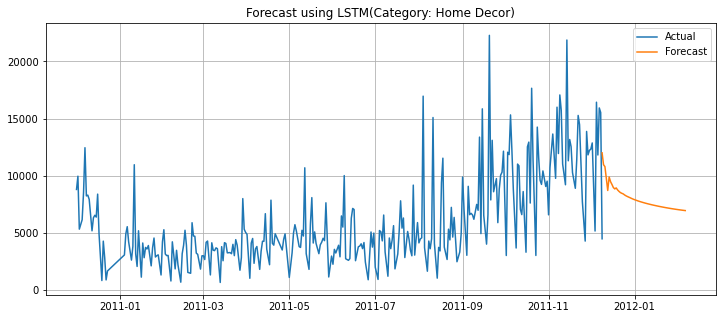

In [46]:
#Plot-3

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(df1.index,scaler.inverse_transform(new_df))
plt.plot(future_dates,scaler.inverse_transform(lst_op))
plt.title('Forecast using LSTM(Category: Home Decor)')
plt.legend(('Actual', 'Forecast'))

In [49]:
# Exponential Smoothing

model_exp = ExponentialSmoothing(train, seasonal_periods=15,
                                 trend='add', seasonal='mul', damped=True
                                ).fit(optimized=True,use_boxcox=True)
pred = np.round(model_exp.forecast(len(test)))
pred = model_exp.predict(start= 275, end=304)
EXP_perf = np.round(sqrt(mean_squared_error(test['Quantity'],pred)))
print(EXP_perf)

4663.0


In [50]:
model_exp.summary()

Dep. Variable:,endog,No. Observations:,275
Model:,ExponentialSmoothing,SSE,2189850350.434
Optimized:,True,AIC,4409.840
Trend:,Additive,BIC,4482.176
Seasonal:,Multiplicative,AICC,4413.856
Seasonal Periods:,15,Date:,"Fri, 17 Dec 2021"
Box-Cox:,True,Time:,15:36:04
Box-Cox Coeff.:,0.15729,,
,coeff,code,optimized
smoothing_level,0.0526316,alpha,True
smoothing_slope,0.0526316,beta,True


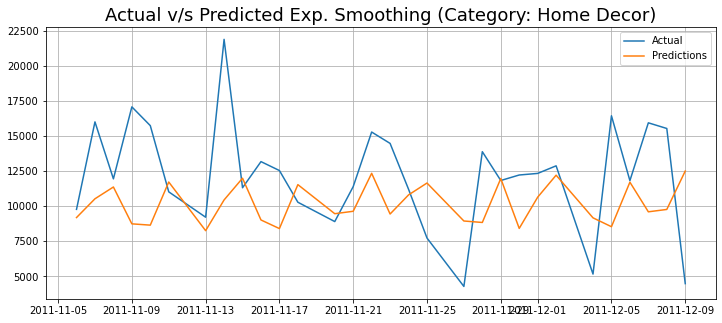

In [51]:
#Plot-1

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(test.index,test['Quantity'])
plt.plot(test.index,pred)
plt.title('Actual v/s Predicted Exp. Smoothing (Category: Home Decor)',fontsize= 18)
plt.legend(('Actual', 'Predictions'))
plt.show()

In [52]:
#Forecast
model2=ExponentialSmoothing(df1['Quantity'], seasonal_periods=30,
                                 trend='add', seasonal='mul', damped=True
                                )
model2= model2.fit(optimized=True,use_boxcox=True)

pred= model2.predict(start=len(df1),end=len(df1)+59).rename('Exp. Smoothing Predictions')
pred.index= future_dates

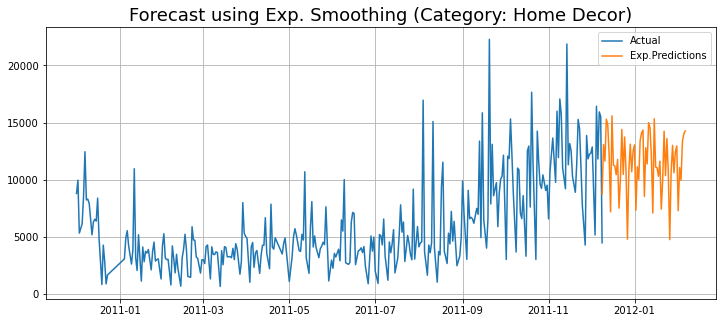

In [120]:
#Plot-2

plt.figure(figsize=(12,5))
plt.grid()
plt.plot(df1.index,df1['Quantity'])
plt.plot(pred.index,pred)
plt.title('Forecast using Exp. Smoothing (Category: Home Decor)',fontsize= 18)
plt.legend(('Actual', 'Exp.Predictions'))
plt.show()

### Prophet model

In [53]:
df1.tail()

,ds,Quantity
ds,,
2011-12-05,2011-12-05,16433
2011-12-06,2011-12-06,11815
2011-12-07,2011-12-07,15932
2011-12-08,2011-12-08,15529
2011-12-09,2011-12-09,4485


In [54]:
df1.columns= ['ds','y']

df1['yoriginal']= df1['y']
df1['y']= np.log(df1['yoriginal'])


data = df1.loc[:,['ds','y']]
 
    #Split data
train = data[:int(0.9*(len(data)))]
test = data[int(0.9*len(data)):]

# Train the model
m = Prophet()
m.fit(train)

#Validate model on test data
y_pred=m.predict(test)
y_pred.columns
y_pred[['ds','yhat_lower', 'yhat_upper','yhat']]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat_lower,yhat_upper,yhat
0,2011-11-04,8.678139,9.735752,9.212149
1,2011-11-06,8.076077,9.104574,8.583873
2,2011-11-07,8.855599,9.896625,9.378275
3,2011-11-08,8.982551,9.978696,9.455438
4,2011-11-09,8.792251,9.862509,9.349332
5,2011-11-10,9.121799,10.140430,9.616769
6,2011-11-11,8.730082,9.771020,9.270216
7,2011-11-13,8.139745,9.184631,8.641940
8,2011-11-14,8.890885,9.925807,9.436342
9,2011-11-15,8.973383,10.018691,9.513506


In [55]:
# Forecast

future= m.make_future_dataframe(periods=95, freq='D')
fcast=m.predict(future)
#fcast= fcast[-60:]
fcast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [56]:
fcast[['ds','yhat_lower', 'yhat_upper','yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2010-12-01,8.105774,9.114148,8.597465
1,2010-12-02,8.324719,9.345046,8.849082
2,2010-12-03,8.007383,8.957597,8.486710
3,2010-12-05,7.299125,8.356642,7.826795
4,2010-12-06,8.096418,9.132825,8.605377
...,...,...,...,...
364,2012-02-02,9.790077,10.843768,10.313578
365,2012-02-03,9.385313,10.502827,9.967025
366,2012-02-04,9.773588,10.837934,10.295528
367,2012-02-05,8.772084,9.904201,9.338749


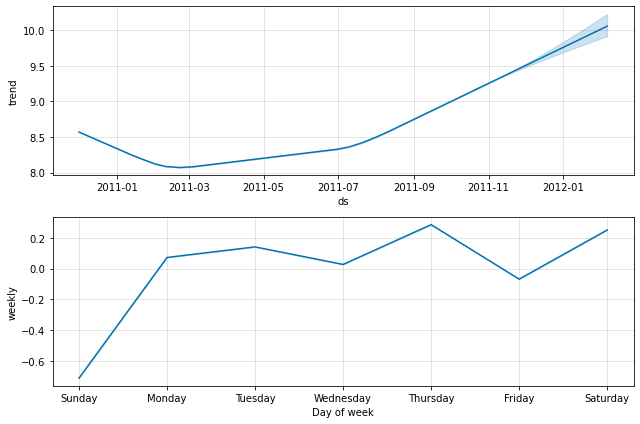

In [57]:
#Plot-1
plot2= m.plot_components(fcast)

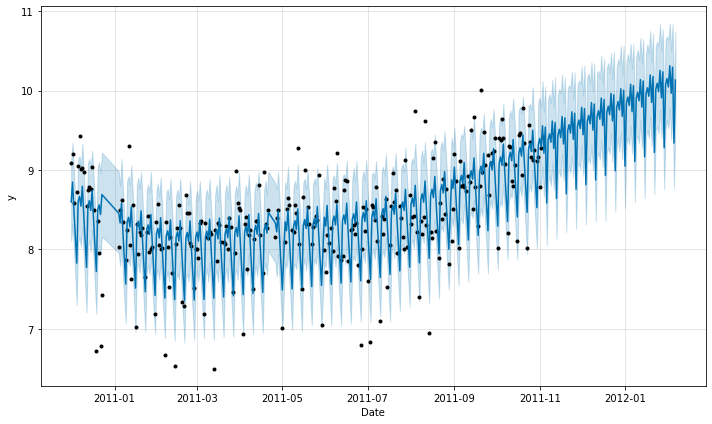

In [58]:
m.plot(fcast,xlabel = 'Date');


In [59]:
# Convert back to original values



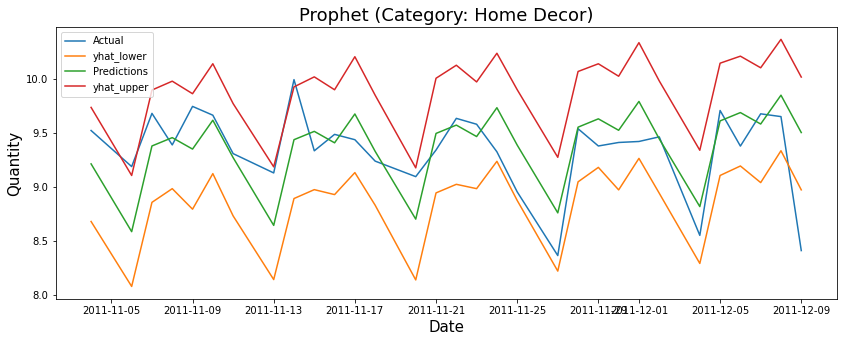

In [60]:
plt.figure(figsize=(14,5))
plt.title('Prophet (Category: Home Decor)', fontsize= 18)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Quantity',fontsize=15)
plt.plot(test.index,test['y'])
plt.plot(test.index,y_pred[['yhat_lower','yhat','yhat_upper']])
plt.legend(('Actual','yhat_lower', 'Predictions','yhat_upper'))
plt.show()

In [61]:
fcast_org = fcast # make sure we save the original forecast data
fcast_org['yhat'] = np.exp(fcast_org['yhat'])
fcast_org['yhat_lower'] = np.exp(fcast_org['yhat_lower'])
fcast_org['yhat_upper'] = np.exp(fcast_org['yhat_upper'])

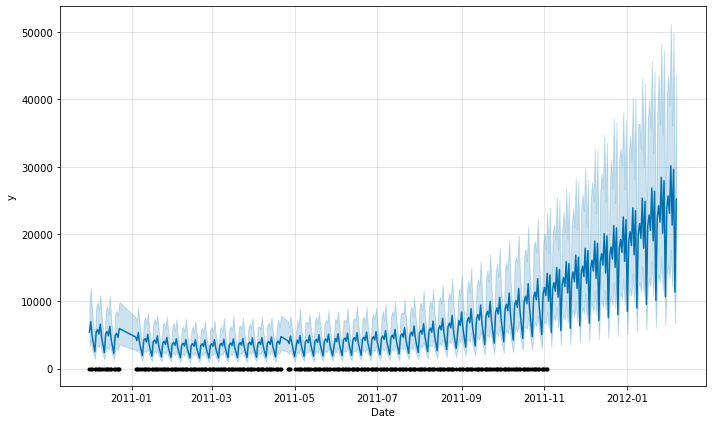

In [12]:
m.plot(fcast_org,xlabel = 'Date');

In [66]:
df_org= pd.DataFrame(fcast_org)

In [68]:
y_pred=df_org['yhat'][len(train):len(df1)]
prop_perf=sqrt(mean_absolute_error(test['y'],y_pred))

NameError: name 'mean_absolute_error' is not defined

In [63]:
print("The performance of ARIMA model :",arima_model_perf)
print("The performance of EXP. model :",EXP_perf)
print("The performance of LSTM model :",lstm_perf)
print("The performance of Prophet model :",prop_perf)

The performance of ARIMA model : 4324.260853805385
The performance of EXP. model : 4663.0
The performance of LSTM model : 5791.206620841326
The performance of Prophet model : 12984.679496052398


In [16]:
#Plot-4 Using plotly

trace1 = go.Scatter(x= df1['ds'], y=df1["yoriginal"],
                    name= 'Actual Quantity')

upper_limit = go.Scatter(name = 'upper limit',x= df1['ds'],
                         y = df_org['yhat_upper'])

lower_limit = go.Scatter(
    name= 'lower limit',x= df1['ds'],
    y = df_org['yhat_lower'])

data = [trace1, lower_limit, upper_limit]

layout = dict(title='FbProphet Forecast (Category : Home Decor) ',
             xaxis=dict(title = 'Date', ticklen=2, zeroline=True))

figure=dict(data=data,layout=layout)
py.offline.iplot(figure)